In [4]:
!ls

html	MovieSummaries	    processed_data  save
images	MovieSummaries.zip  README.md


In [3]:
cd ./drive/MyDrive/ada-2022-project-datakungfu/

/content/drive/MyDrive/ada-2022-project-datakungfu


In [1]:
import re
import json
from string import punctuation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from gensim import corpora
from gensim.models import LdaModel, TfidfModel
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import pyLDAvis.gensim_models
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')

# ignore deprecated warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

c:\Download\programming\anaconda3\envs\ada\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package stopwords to C:\Users\El Psy
[nltk_data]     Congroo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\El Psy
[nltk_data]     Congroo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Loading

### Character Metadata

In [2]:
df_character = pd.read_csv("./MovieSummaries/character.metadata.tsv", sep='\t', header=None)
df_character.columns = ['Wikipedia movie ID', 
'Freebase movie ID', 
'Movie release date',
'Character name',
'Actor date of birth', 
'Actor gender', 
'Actor height(in meters)', 
'Actor ethnicity(Freebase ID)', 
'Actor name', 
'Actor age at movie release',
'Freebase character/actor map ID',
'Freebase character ID',
'Freebase actor ID']
df_character.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height(in meters),Actor ethnicity(Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [3]:
# number of samples without missing values
print("{}/{} samples without any missing value.".format(len(df_character.dropna()), len(df_character)))


45264/450669 samples without any missing value.


### Movie Metadata

In [4]:
df_movie = pd.read_csv("./MovieSummaries/movie.metadata.tsv", sep='\t', header=None)
df_movie.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Name', 'Release date', 'Revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
df_movie.head()

,Wikipedia movie ID,Freebase movie ID,Name,Release date,Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


### Plot summary

In [5]:
df_summary = pd.read_csv("./MovieSummaries/plot_summaries.txt", sep='\t', header=None)
df_summary.columns = ['Wikipedia movie ID', 'Summary']
df_summary.head()

,Wikipedia movie ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


### Name Cluster

In [6]:
df_name_cluster = pd.read_csv("./MovieSummaries/name.clusters.txt", sep='\t', header=None)
df_name_cluster.columns = ['Character Name', 'Freebase Movie ID']
df_name_cluster.head()

,Character Name,Freebase Movie ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


### Tvtropes Cluster

In [7]:
chartype_path = "./MovieSummaries/tvtropes.clusters.txt"


def read_tvtropes(char_cluster_path):
    df = pd.read_csv(char_cluster_path, sep='\t', header=None)
    df.columns = ['Type', 'raw info']
    # extract information from "Raw Info"
    for i in range(len(df)):
        char_info = json.loads(df.loc[i, 'raw info'])
        for name,val in char_info.items():
            df.loc[i, name.title()] = val
    df.drop('raw info', axis=1, inplace=True)
    return df

df_chartype = read_tvtropes(chartype_path)
print(df_chartype.shape)
df_chartype.head()

(501, 5)


,Type,Char,Movie,Id,Actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


### Movie metadata full

In [8]:
df_movie_full = pd.read_csv("./MovieSummaries/movies_metadata.csv")

C:\Users\El Psy Congroo\AppData\Local\Temp\ipykernel_17000\1046913326.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movie_full = pd.read_csv("./MovieSummaries/movies_metadata.csv")


#### Ratings

In [9]:
df_ratings = pd.read_csv("./MovieSummaries/ratings.csv")

## Data Wrangling

#### Clean character data

In [10]:
df_character.dropna(inplace=True)

#### Release Date Processing

Convert release date to release year

In [11]:
print("{}/{} samples without any missing value.".format(len(df_movie.dropna()), len(df_movie)))
df_movie = df_movie.dropna().reset_index(drop=True)

# transform Release date to integer, month and day are dropped for simplicity.
df_movie["Release date"] = df_movie["Release date"].apply(lambda x: int(x.split('-')[0]))

# only consider movies released after 1920
df_movie = df_movie[df_movie["Release date"] >= 1920]

8243/81741 samples without any missing value.


In [12]:
# Release period for df_movie_full
def get_release_period(release_date):
    """ every 10 years considered as a period """
    interval = 10
    if pd.isnull(release_date):
        return release_date
    else:
        release_year = int(release_date.split('-')[0])
        return (release_year + interval - 1) // interval * interval

df_movie_full["release_period"] = df_movie_full["release_date"].apply(get_release_period)

#### Revenue Processing

In [13]:
def ratio_per_year(x):
    sum = x.Revenue.sum()
    return x.Revenue/sum

In [14]:
group_by_year = df_movie.groupby("Release date").apply(ratio_per_year)
group_by_year

Release date      
1920          2574    1.000000
1921          593     0.569620
              3314    0.113924
              4117    0.316456
1923          12      0.456395
                        ...   
2012          7959    0.002308
              7982    0.012923
              8037    0.010032
              8061    0.004218
              8139    0.003447
Name: Revenue, Length: 8240, dtype: float64

In [15]:
for i,v in group_by_year.iteritems():
    df_movie.loc[i[1], "Revenue_ratio"] = v

print(df_movie.shape)
df_movie.head()

(8240, 10)


,Wikipedia movie ID,Freebase movie ID,Name,Release date,Revenue,Runtime,Languages,Countries,Genres,Revenue_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000946
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",0.153143
2,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",0.001675
3,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",0.303695
4,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000002


### Merge Movie meta full data and ratings

In [16]:
average_ratings = df_ratings.groupby("movieId").mean()[['rating']].reset_index()
average_ratings[["id"]] = average_ratings[["movieId"]].astype(str)

In [17]:
df_movie_rating = pd.merge(df_movie_full, average_ratings, on=['id'])

### Plot Summary Processing

In [18]:
df_high_150 = df_movie_rating.sort_values(by="rating",ascending=False)[:150]

In [19]:
df_high_150_overview = df_high_150["overview"].dropna()

In [20]:
def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

In [21]:
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

stopWords = set(stopwords.words('english'))
punct = str.maketrans({key:"" for key in string.punctuation})
no_digit = str.maketrans('', '', string.digits)

data_summaries = []
for i in df_high_150_overview:
    sentence =[]
    # Delete punctuation
    line = i.translate(punct)

    # Delete digits
    line = line.translate(no_digit)

    line = line.lower()

    # Tokenization
    words = word_tokenize(line)

    # Stemming
    tagged_sent = pos_tag(words)
    wnl = WordNetLemmatizer()
    lemmas_sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos))

    # Remove stopwords
    for w in lemmas_sent:
        if w not in stopWords and w.lower() not in stopWords:
            sentence.append(w)
            
    data_summaries.append(sentence)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\El Psy Congroo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\El Psy
[nltk_data]     Congroo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\El Psy
[nltk_data]     Congroo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [22]:
data = [content for content in data_summaries]
dictionary = corpora.Dictionary(data)
# dictionary.save(r'../data/dictionary.dict')

In [23]:
corpus = [dictionary.doc2bow(s) for s in data]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## Data Analysis

### Relationship between Movie Country and Movie Revenue

In [24]:
print("df_movie shape:", df_movie.shape)
df_movie.head()

df_movie shape: (8240, 10)


,Wikipedia movie ID,Freebase movie ID,Name,Release date,Revenue,Runtime,Languages,Countries,Genres,Revenue_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000946
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",0.153143
2,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",0.001675
3,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",0.303695
4,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000002


Mean overall: 4.84395e+07
Median overall: 1.08866e+07


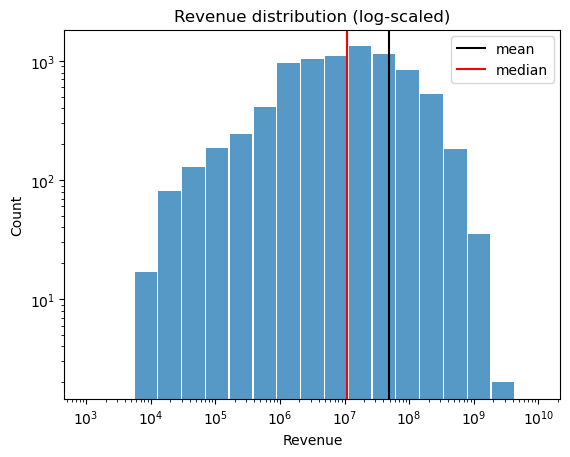

In [25]:
bins = np.logspace(3, 10, 20)
g = sns.histplot(x=df_movie["Revenue"], bins=bins, shrink=0.95)
g.set_xscale("log")
g.set_yscale("log")
plt.axvline(df_movie["Revenue"].mean(), c='black', label="mean")
plt.axvline(df_movie["Revenue"].median(), c='r', label="median")
plt.legend()
plt.title("Revenue distribution (log-scaled)")

print("Mean overall: {:5g}".format(df_movie["Revenue"].mean()))
print("Median overall: {:5g}".format(df_movie["Revenue"].median()))

In [26]:
from collections import Counter, defaultdict

# movie revenue for each country
country_revenue = defaultdict(list)
for index, row in df_movie.iterrows():
    countries = json.loads(row["Countries"]).values()
    if len(countries) >= 2:
        continue
    for country in countries:
        country_revenue[country].append(row["Revenue"])

print("Total {} countries.".format(len(country_revenue)))

Total 40 countries.


Top 15 country, revenue


Text(0.5, 1.0, 'average movie revenue for top 15 countries')

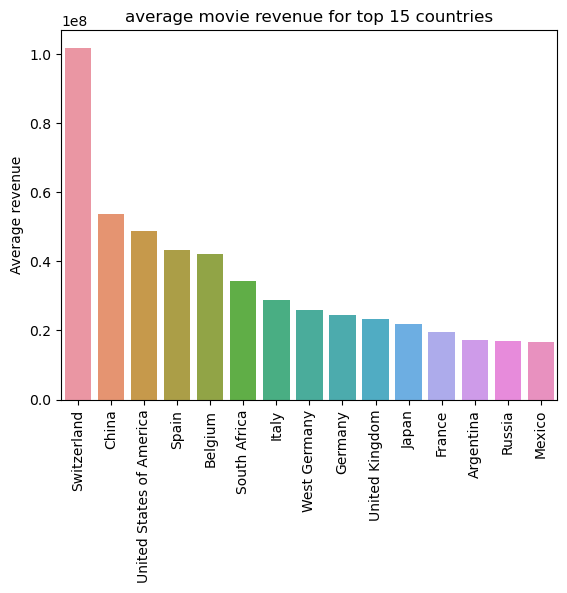

In [27]:
# mean for each country
mean_ctry_rev = {k:sum(v)/len(v) for k,v in country_revenue.items()}
# sroted mean for each country
sorted_mcr = sorted(mean_ctry_rev.items(), key=lambda x:x[1], reverse=True)
sorted_mcr = pd.Series(*list(zip(*sorted_mcr))[::-1], name="Average revenue")

topk = 15
print("Top {} country, revenue".format(topk))
sns.barplot(x=sorted_mcr.index[:topk], y=sorted_mcr[:topk])
plt.ylabel("Average revenue")
plt.xticks(rotation=90)
plt.title("average movie revenue for top {} countries".format(topk))

### Relationship between Movie Language and Movie Revenue

In [28]:
from collections import Counter, defaultdict

# movie revenue for each language
language_revenue = defaultdict(list)
language_count = Counter()
for index, row in df_movie.iterrows():
    languages = json.loads(row["Languages"]).values()
    # if len(languages) >= 2:
    #     continue
    for language in languages:
        language_count[language] += 1
        language_revenue[language].append(row["Revenue"])

print("Total {} languages.".format(len(country_revenue)))

Total 40 languages.


Top 15 language, revenue


Text(0.5, 1.0, 'average movie revenue for top 15 languages')

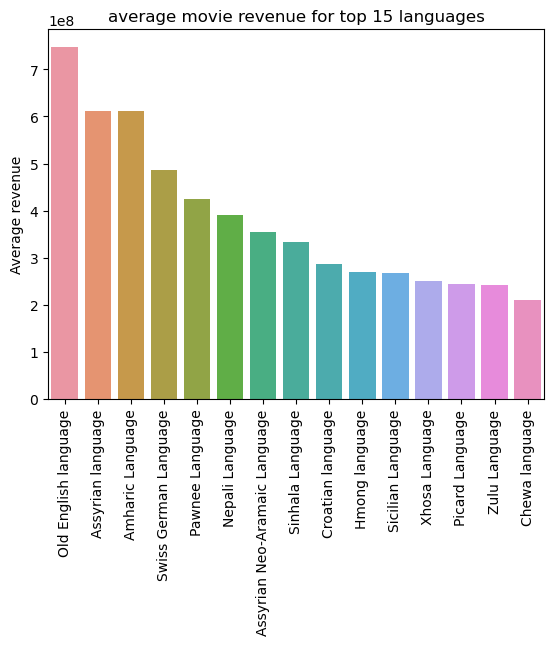

In [29]:
# mean for each language
mean_lang_rev = {k:sum(v)/len(v) for k,v in language_revenue.items()}
# sroted mean for each language
sorted_mlr = sorted(mean_lang_rev.items(), key=lambda x:x[1], reverse=True)
sorted_mlr = pd.Series(*list(zip(*sorted_mlr))[::-1], name="Average revenue")

topk = 15
print("Top {} language, revenue".format(topk))
sns.barplot(x=sorted_mlr.index[:topk], y=sorted_mlr[:topk])
plt.ylabel("Average revenue")
plt.xticks(rotation=90)
plt.title("average movie revenue for top {} languages".format(topk))

Text(0.5, 1.0, 'Revenue - Release data')

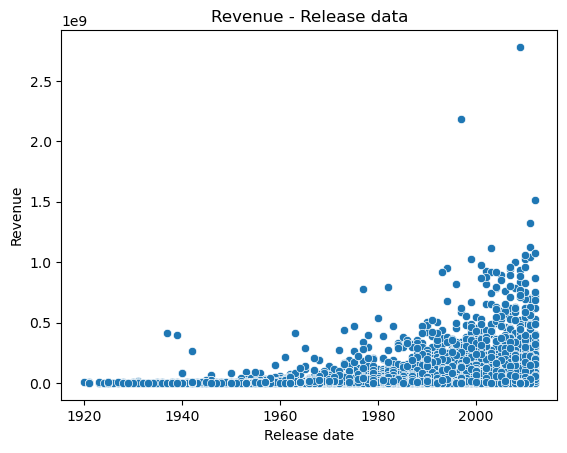

In [30]:
# Year - Revnue
sns.scatterplot(x=df_movie["Release date"], y=df_movie["Revenue"])
plt.title("Revenue - Release data")

### Study movie genres

#### Relationship between movie genres and average movie revenue (in `df_movie`)

In [31]:
from collections import Counter, defaultdict

# movie revenue for each language
genre_revenue = defaultdict(list)
genre_count = Counter()
for index, row in df_movie.iterrows():
    genres = json.loads(row["Genres"]).values()
    for genre in genres:
        genre_count[genre] += 1
        genre_revenue[genre].append(row["Revenue"])

print("Total {} genres.".format(len(country_revenue)))

Total 40 genres.


Top 15 genre, revenue


Text(0.5, 1.0, 'average movie revenue for top 15 genres')

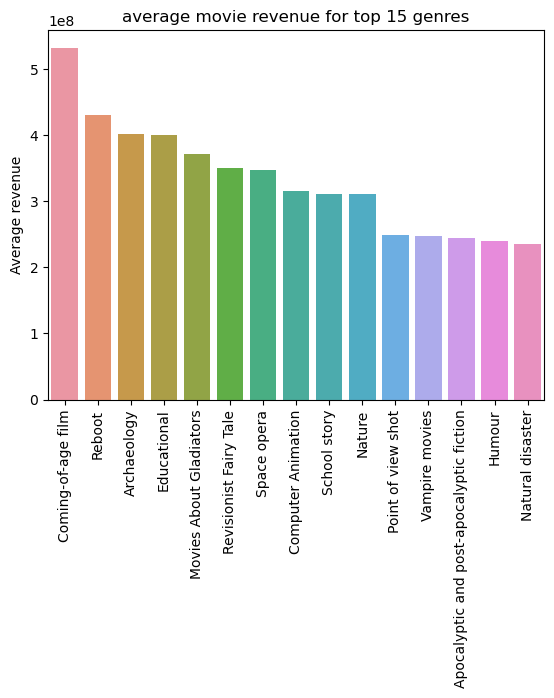

In [32]:
# mean for each genre
mean_genre_rev = {k:sum(v)/len(v) for k,v in genre_revenue.items()}
# sroted mean for each genre
sorted_mgr = sorted(mean_genre_rev.items(), key=lambda x:x[1], reverse=True)
sorted_mgr = pd.Series(*list(zip(*sorted_mgr))[::-1], name="Average revenue")

topk = 15
print("Top {} genre, revenue".format(topk))
sns.barplot(x=sorted_mgr.index[:topk], y=sorted_mgr[:topk])
plt.ylabel("Average revenue")
plt.xticks(rotation=90)
plt.title("average movie revenue for top {} genres".format(topk))

In [33]:
# clean up memory
del(sorted_mgr)

#### Evolution of the popularity of top-k genres in the history (`df_movie`)

In [34]:
# drop row if na in Release year or Genres
df_genre = df_movie[df_movie["Release date"].notna() & df_movie["Genres"].notna()].copy()
# compute release uear
df_genre["Release year"] = df_genre["Release date"]

In [35]:
# extract genre -> study on top 5 (over all) -> evolution
from collections import Counter

# find top k
k = 5
genre_count = Counter()
for index, row in df_genre.iterrows():
    genres = json.loads(row["Genres"]).values()
    for genre in genres:
        genre_count[genre] += 1
topk = dict(genre_count.most_common(5))

# dict: year -> dict[genre -> count]
genres_cnt_year = dict()
for index, row in df_genre.iterrows():
    genres = json.loads(row["Genres"]).values()
    for genre in genres: # by depends on what is request js
        year = row["Release year"]
        if year not in genres_cnt_year:
            genres_cnt_year[year] = Counter()
        genres_cnt_year[year][genre] += 1

# dict: year -> count num in year
movie_cnt_year = df_genre["Release year"].value_counts().to_dict()

# divide each by count in the same year
genre_over_year = pd.DataFrame(index=genres_cnt_year.keys(), columns=topk.keys())
print(genre_over_year.shape)
for year,row in genre_over_year.iterrows():
    for genre,tot in topk.items():
        genre_over_year.loc[year, genre] = genres_cnt_year[year][genre] / movie_cnt_year[year]
genre_over_year.sort_index(inplace=True)


(92, 5)


In [36]:
# Before 1920 and after 2010, number of movie samples is too small
tmp = genre_over_year[(genre_over_year.index > 1920) & (genre_over_year.index <= 2010)]
tmp.head()

,Drama,Comedy,Romance Film,Thriller,Action
1921,1.0,0.666667,0.333333,0.0,0.0
1923,0.5,0.0,0.0,0.0,0.0
1924,0.666667,0.333333,0.666667,0.0,0.0
1925,0.6,0.4,0.0,0.0,0.0
1926,0.0,0.5,0.5,0.0,0.5


Print results to export to `js` widget file with:
```python
    res = tmp.index  # print index
    N_PER_LINE = 20
    for i in range(0, len(res), N_PER_LINE):
        print(*res[i:i+N_PER_LINE], sep=", ", end=",\n")
```
and with
```python
    res = list(tmp[list(topk.keys())[4]]) # change number to select a different genre
    N_PER_LINE = 10
    for i in range(0, len(res), N_PER_LINE):
        print(*res[i:i+N_PER_LINE], sep=", ", end=",\n")
```

In [37]:
# clean
del(tmp)
del(genre_over_year)
del(df_genre)

### Study actor age

#### relationship between actor age and movie revenue

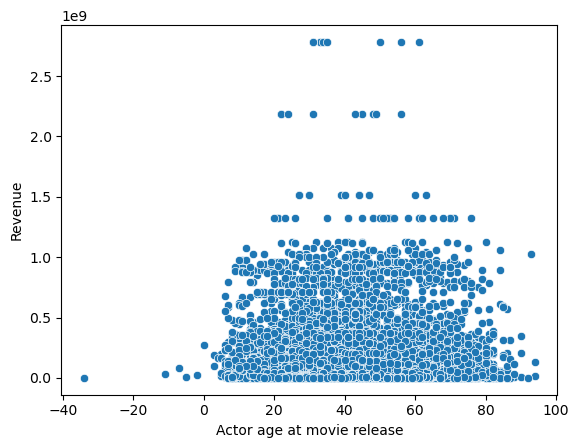

In [38]:
df_actor_movie = df_character.merge(df_movie, on="Freebase movie ID", how="left").dropna()
sns.scatterplot(data=df_actor_movie, x="Actor age at movie release", y="Revenue")

# clean
del(df_actor_movie)

#### Evolution of every actor age over time

Compute actor age at movie release: 

<AxesSubplot:xlabel='Movie release year', ylabel='Actor age'>

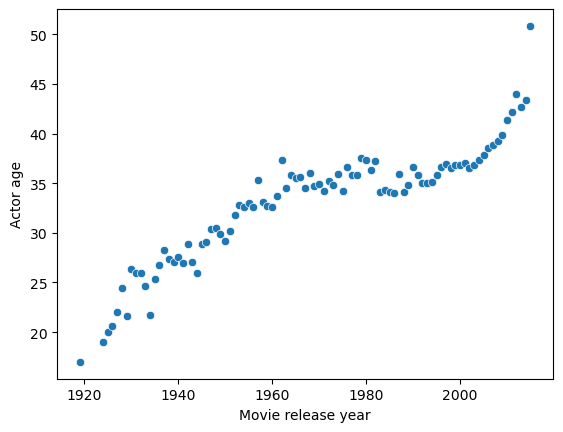

In [39]:
# Extract movie release year
df_character["Movie release year"] = df_character["Movie release date"].apply(lambda x: int(x.split('-')[0]))
# Compute actor age at movie release
df_character["Actor birth year"] = df_character["Actor date of birth"].apply(lambda  x: int(x.split('-')[0]))
df_character["Actor age"] = df_character["Movie release year"] - df_character["Actor birth year"]
# Compute average actor age in each year
age_over_time = df_character[["Movie release year", "Actor age"]].groupby(by="Movie release year").mean()

# display results
sns.scatterplot(x=age_over_time.index, y=age_over_time['Actor age'], data=age_over_time)

Print results and copy to `js` widget file with the following code:
```python
    res = list(age_over_time["Actor age"])
    for i in range(0, len(res), 10):
        print(*res[i:i+10], sep=", ", end=",\n")
```

In [40]:
# clean 
del(age_over_time)

### Relation between budget and rating

In [41]:
df_movie_rating_budget = df_movie_rating[df_movie_rating["budget"] != "0"]
df_movie_rating_budget[["money"]] = df_movie_rating_budget[["budget"]].astype(int)
df_movie_rating_budget.columns

C:\Users\El Psy Congroo\AppData\Local\Temp\ipykernel_17000\2632445051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_rating_budget[["money"]] = df_movie_rating_budget[["budget"]].astype(int)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'release_period', 'movieId', 'rating',
       'money'],
      dtype='object')

In [42]:
budget = df_movie_rating_budget["money"]
rating = df_movie_rating_budget["rating"]

In [43]:
def create_data_budget(b, r):
    res = []
    for i in range(len(b)):
        res.append([b, r])
    return res

budget_rating_data = create_data_budget(budget, rating)

In [44]:
from pyecharts.charts import Scatter
import pyecharts.options as opts

c = (
    Scatter()
    .add_xaxis(rating)
    .add_yaxis("Movies", budget, label_opts=opts.LabelOpts(is_show=False),symbol_size=20)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Scatter Budget-Rating"),
        visualmap_opts=opts.VisualMapOpts(
            type_='color',
            max_=300000000,
            pos_bottom = 50,pos_right = 0),
    )
    .render('./html/budget_rating.html')
)

### Study actor gender over time

Leading question: how does the fraction of female actors change over time ?

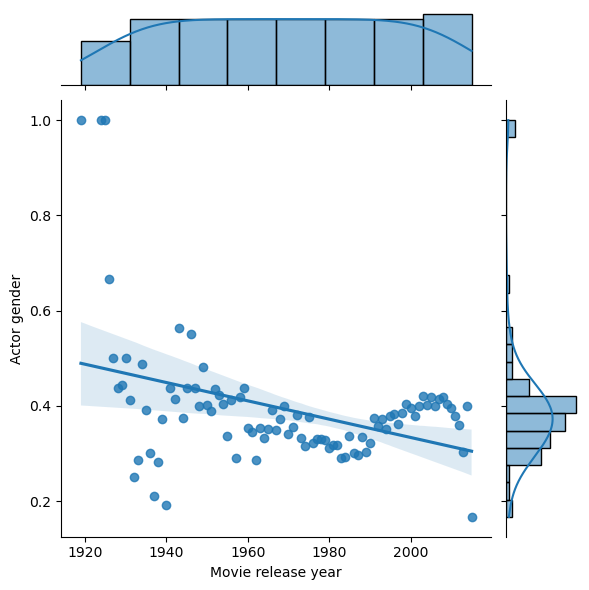

In [45]:
# Number of actors in each year
count_actor = df_character[["Movie release year", "Actor gender"]].groupby(by="Movie release year").count()
# Number of female actors in each year
count_female = df_character[df_character["Actor gender"] == "F"][["Movie release year", "Actor gender"]].groupby(by="Movie release year").count()
# Fraction of female actors in each year
female_over_time = count_female / count_actor

# display results
sns.jointplot(x=female_over_time.index, y='Actor gender', data=female_over_time, kind="reg")

Print results and copy to `js` widget file if needed:

```python
    res = list(female_over_time["Actor gender"])
    for i in range(0, len(res), 10):
        print(*res[i:i+10], sep=", ", end=",\n")
```

In [46]:
# clean
del(count_actor)
del(count_female)

### Country Map

#### Data Save and Loading

In [47]:
# Save intermediate data for speeding up the calculation after
def save_list(data, name):
    d=np.array(data)
    np.save('./processed_data/' + name, d)

def load_list(name):
    data = np.load('./processed_data/' + name)
    data_list = data.tolist()
    return data_list

In [48]:
# Get dictionary value
def get_dict_value(string):
    dict_1 = eval(string)
    items=dict_1.items()
    for item in items:
        return item[1]

In [49]:
df_movie_1980 = df_movie[df_movie["Release date"] < 1990]
df_movie_1990 = df_movie.loc[(df_movie["Release date"] >= 1990) & (df_movie["Release date"] < 2005)]
df_movie_2020 = df_movie[df_movie["Release date"] >= 2005]

In [50]:
countries_1980 = df_movie_1980["Countries"].apply(lambda x: get_dict_value(x))
countries_1990 = df_movie_1990["Countries"].apply(lambda x: get_dict_value(x))
countries_2020 = df_movie_2020["Countries"].apply(lambda x: get_dict_value(x))

In [51]:
# Count the number of elements for each countries set
def count_count(countries):
    count_country = countries.value_counts()
    count_c_values = count_country.values
    count_c_index = count_country.index
    return count_c_values, count_c_index

In [52]:
data_map_1980 = []
data_map_1990 = []
data_map_2020 = []
c1, c2 = count_count(countries_1980)
c3, c4 = count_count(countries_1990)
c5, c6 = count_count(countries_2020)

for i in range(len(c1)):
    data_map_1980.append([str(c2[i]), c1[i]])

for i in range(len(c3)):
    data_map_1990.append([str(c4[i]), c3[i]])

for i in range(len(c5)):
    data_map_2020.append([str(c6[i]), c5[i]])

In [53]:
save_list(data_map_1980, "country_1980")
save_list(data_map_1990, "country_1990")
save_list(data_map_2020, "country_2020")

In [54]:
try1980 = load_list("country_1980.npy")
try1990 = load_list("country_1990.npy")
try2020 = load_list("country_2020.npy")

In [55]:
from pyecharts import options as opts
from pyecharts.charts import Map

def create_world_map():
    ''' 
     Function: Generate World HeatMap
    '''
    (   
        Map()
        .add(
            series_name="1920-1980", 
            data_pair=try1980, 
            maptype="world", 
        )
        .add(
            series_name="1990-2005", 
            data_pair=try1990, 
            maptype="world", 
        )
        .add(
            series_name="2005-2012", 
            data_pair=try2020, 
            maptype="world", 
        )
        
        .set_global_opts(
            # title_opts=opts.TitleOpts(title="Movie maps in different periods")
            visualmap_opts=opts.VisualMapOpts(max_=100, is_piecewise=False),
        )
        
        .set_series_opts(
            label_opts=opts.LabelOpts(is_show=False, color="blue")
        )
        
        .render("./html/World_map.html")
    )

create_world_map()

### Movie Title Analysis

In [56]:
movie_name = df_movie["Name"].astype('str')
movie_name

0                 Ghosts of Mars
1       Alexander's Ragtime Band
2                        Henry V
3                   Mary Poppins
4                 New Rose Hotel
                  ...           
8238                       Wilde
8239           Coming to America
8240             Spaced Invaders
8241              State and Main
8242               Guilty as Sin
Name: Name, Length: 8240, dtype: object

In [57]:
def transform_mask(imagename):
    mask = np.array(Image.open(f"./images/{imagename}.png"))
    mask = mask[:,:,0] # transform 3d image to 2d for easier visualization

    def transform_format(val):
        if val.any()== 0:
            return 255
        else:
            return val

    # Transform your mask into a new one that will work with the function
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    for i in range(len(mask)):
        transformed_mask[i] = list(map(transform_format,mask[i]))

    return transformed_mask


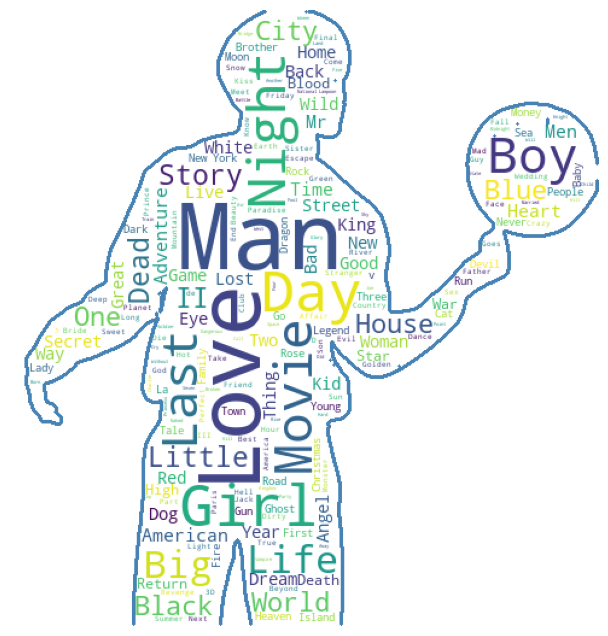

In [58]:
title_corpus = ' '.join(movie_name)
mask = np.array(Image.open("./images/background1.png"))
mask_trans = mask[:, :, 0]
mask_trans = transform_mask("background1")
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', mask=mask_trans, height=800, width=600, contour_width = 3,\
    contour_color = 'steelblue').generate(title_corpus)
title_wordcloud.to_file("./images/movie_title1.png")
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

#### Pyechart

In [59]:
print(df_movie.shape)
df_movie.head()

(8240, 10)


,Wikipedia movie ID,Freebase movie ID,Name,Release date,Revenue,Runtime,Languages,Countries,Genres,Revenue_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000946
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",0.153143
2,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",0.001675
3,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",0.303695
4,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000002


In [60]:
df_movie_2000 = df_movie[df_movie["Release date"] < 1995]
df_movie_2020 = df_movie[df_movie["Release date"] >= 1995]
len(df_movie_2020)

4619

In [61]:
import string
# Create a word corpus for titles
def create_title_corpus(df_movie):
    corpus = []
    for index, row in df_movie.iterrows():
        for c in df_movie["Name"][index].split():
            if c.lower() not in stopWords and c not in punctuation and c not in string.digits:
                corpus.append(c)
    return corpus

In [62]:
from collections import Counter
# Count words frequencies in the corpus
def create_title_sta(corpus):
    count_corpus = Counter(corpus)
    count_title = count_corpus.most_common()  

    title_data = []
    for i in range(len(count_title)):
        title_data.append([count_title[i][0], count_title[i][1]])

    return title_data

In [63]:
corpus_2000 = create_title_corpus(df_movie_2000)
title_data_2000 = create_title_sta(corpus_2000)

corpus_2020 = create_title_corpus(df_movie_2020)
title_data_2020 = create_title_sta(corpus_2020)

In [64]:
# Count the number of words differences during two datasets
def title_diff(data1, data2):
    data_diff = []
    for i in range(len(data1)):
        word, count = data1[i]
        for j in data2:
            if j[0] == word:
                if count - j[1] > 0:
                    data_diff.append([word, count-j[1]])
    return data_diff

In [65]:
data_title_diff = title_diff(title_data_2020, title_data_2000)
save_list(data_title_diff, "title_diff")

In [66]:
from pyecharts import options as opts
from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType

# Generating WordCloud by pyecharts
(
  WordCloud()
  .add("Title",
        data_title_diff,
        word_size_range=[20, 100],
        shape=SymbolType.DIAMOND
      )

  .set_series_opts(
            label_opts=opts.LabelOpts(is_show=False, color="blue")
        )
  .render("./html/Word_cloud_diff.html")
)

'c:\\DocProgram\\EPFL\\ada-2022-project-datakungfu\\html\\Word_cloud_diff.html'

### Popularity and ratings

In [67]:
df_movie_rating["popularity"][:5]

0    21.946943
1    17.015539
2    17.924927
3    14.686036
4     7.284477
Name: popularity, dtype: object

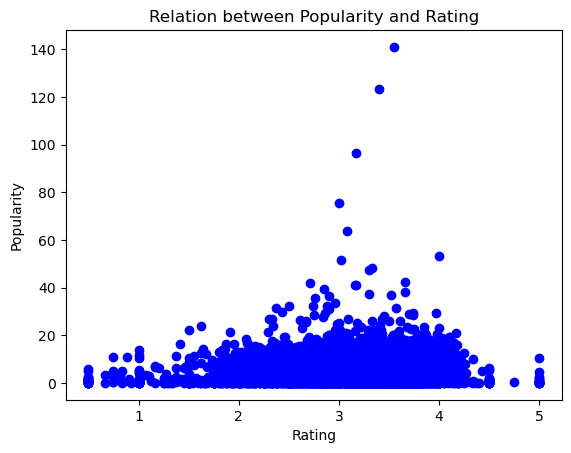

In [68]:
import matplotlib.pyplot as plt

y1 = df_movie_rating["popularity"]
x1 = df_movie_rating["rating"]
plt.xlabel('Rating')
plt.ylabel('Popularity')
plt.title("Relation between Popularity and Rating")
plt.plot(x1,y1, 'o',color='b')
plt.savefig("./images/pop_rating.jpg")
plt.show()

### Movies with the highest rating

In [69]:
df_movie_rating.sort_values(by="rating",ascending=False, inplace=True)

In [70]:
title_high_rating = df_movie_rating[df_movie_rating["rating"] == 5.0]["title"].to_list()
title_high_rating

['Monster High: Escape from Skull Shores',
 'Any Day Now',
 'Brannigan',
 'Burning Secret',
 'Yellow Rock',
 'Journey to Planet X',
 'Palermo or Wolfsburg',
 'The Price of Sex',
 'The Gypsy and the Gentleman',
 'Brutal',
 'Phil Spector',
 'Refugee',
 'Lightheaded',
 'Harvey',
 'Khel',
 'The Man Behind The Gun']

In [71]:
save_list(title_high_rating, "title_high_rating")

### 150 Movies with the highst rating

In [72]:
df_high_150 = df_movie_rating.sort_values(by="rating",ascending=False)[:150]
df_high_150["genres"]

7387    [{'id': 16, 'name': 'Animation'}, {'id': 10751...
6956                                                   []
6700    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
4806                      [{'id': 14, 'name': 'Fantasy'}]
7538                                                   []
                              ...                        
2866    [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...
5490    [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...
4674                  [{'id': 99, 'name': 'Documentary'}]
2814    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
874                         [{'id': 18, 'name': 'Drama'}]
Name: genres, Length: 150, dtype: object

In [73]:
def get_genres(df):
    g = []
    for index, row in df.iterrows():
        for i in eval(row["genres"]):
            g.append(i["name"])
        
    return g

In [74]:
genres_150 = get_genres(df_high_150)
genres_150_count = create_title_sta(genres_150)
save_list(genres_150, "genres_150_count")

In [75]:
from pyecharts import options as opts
from pyecharts.charts import Pie
from pyecharts.faker import Faker
from pyecharts.globals import ThemeType

# Plot pie of genres of 150 highest rated movies
c = (
    Pie(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
    .add(
        "",
        genres_150_count,
        color = None,
        radius = None,
        center = None,
        rosetype = None,
        is_clockwise = True,
        label_opts = opts.LabelOpts(),
        tooltip_opts = None,
        itemstyle_opts = None,
        # types.Union[types.JSFunc, dict, None]
        encode = None,
        )
    # .set_global_opts(title_opts=opts.TitleOpts(title="Genres fraction of 150 movies with the highest ratings"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    .render("./html/pie_genres_150.html")
)

### Movie Plot Summary Analysis


#### Model without using td-idf

In [76]:
model = LdaModel(corpus,id2word=dictionary,num_topics=5)
model.show_topics()

[(0,
  '0.006*"life" + 0.006*"love" + 0.005*"become" + 0.004*"man" + 0.004*"world" + 0.004*"get" + 0.004*"live" + 0.004*"time" + 0.004*"make" + 0.003*"find"'),
 (1,
  '0.006*"one" + 0.004*"young" + 0.004*"take" + 0.004*"meet" + 0.004*"man" + 0.003*"son" + 0.003*"great" + 0.003*"film" + 0.003*"murder" + 0.003*"heathcliff"'),
 (2,
  '0.008*"film" + 0.007*"life" + 0.006*"one" + 0.005*"take" + 0.004*"elwood" + 0.003*"become" + 0.003*"see" + 0.003*"police" + 0.003*"first" + 0.003*"story"'),
 (3,
  '0.006*"young" + 0.005*"life" + 0.005*"story" + 0.005*"film" + 0.004*"find" + 0.003*"woman" + 0.003*"’" + 0.003*"town" + 0.003*"family" + 0.003*"new"'),
 (4,
  '0.008*"story" + 0.006*"life" + 0.005*"world" + 0.005*"man" + 0.005*"film" + 0.004*"love" + 0.004*"know" + 0.004*"search" + 0.004*"get" + 0.003*"one"')]

#### Model using td-idf

In [77]:
lda = LdaModel(corpus_tfidf, id2word = dictionary, num_topics = 3)
model.save(r'./save/lda_model.model')
model.show_topics()

[(0,
  '0.006*"life" + 0.006*"love" + 0.005*"become" + 0.004*"man" + 0.004*"world" + 0.004*"get" + 0.004*"live" + 0.004*"time" + 0.004*"make" + 0.003*"find"'),
 (1,
  '0.006*"one" + 0.004*"young" + 0.004*"take" + 0.004*"meet" + 0.004*"man" + 0.003*"son" + 0.003*"great" + 0.003*"film" + 0.003*"murder" + 0.003*"heathcliff"'),
 (2,
  '0.008*"film" + 0.007*"life" + 0.006*"one" + 0.005*"take" + 0.004*"elwood" + 0.003*"become" + 0.003*"see" + 0.003*"police" + 0.003*"first" + 0.003*"story"'),
 (3,
  '0.006*"young" + 0.005*"life" + 0.005*"story" + 0.005*"film" + 0.004*"find" + 0.003*"woman" + 0.003*"’" + 0.003*"town" + 0.003*"family" + 0.003*"new"'),
 (4,
  '0.008*"story" + 0.006*"life" + 0.005*"world" + 0.005*"man" + 0.005*"film" + 0.004*"love" + 0.004*"know" + 0.004*"search" + 0.004*"get" + 0.003*"one"')]

In [78]:
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(vis, './html/lda.html')
pyLDAvis.display(vis)

### Prediciton on budget

In [79]:
df_movie_rating_budget.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'release_period', 'movieId', 'rating',
       'money'],
      dtype='object')

In [80]:
# Select features
df_pred = df_movie_rating_budget.dropna(axis=0,subset = ["rating", "popularity", "runtime", "release_date"])
df_pred = df_pred.loc[:, ["rating", "popularity", "runtime", "release_date", "budget"]]

In [81]:
df_pred

,rating,popularity,runtime,release_date,budget
0,3.598930,21.946943,81.0,1995-10-30,30000000
1,3.760163,17.015539,104.0,1995-12-15,65000000
2,3.905544,17.924927,170.0,1995-12-15,60000000
3,2.740334,14.686036,130.0,1995-11-16,58000000
4,3.710181,7.284477,119.0,1995-12-22,98000000
...,...,...,...,...,...
7509,2.560000,1.174113,94.0,2011-03-03,4000000
7523,3.629412,0.947509,107.0,2005-12-30,2196531
7526,3.352299,2.524781,240.0,1999-12-25,20000000
7557,2.875000,0.283443,93.0,1981-12-11,500000


In [82]:
for index, row in df_pred.iterrows():
    df_pred.loc[index, "year"] = df_pred.loc[index, "release_date"][:4]

In [83]:
# Transform element types to float
df_pred[["popularity"]] = df_pred[["popularity"]].astype(float)
df_pred[["budget"]] = df_pred[["budget"]].astype(float)
df_pred[["year"]] = df_pred[["year"]].astype(float)

In [84]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='budget~-1+rating+popularity+runtime+year',data=df_pred)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 budget   R-squared (uncentered):                   0.475
Model:                            OLS   Adj. R-squared (uncentered):              0.474
Method:                 Least Squares   F-statistic:                              479.6
Date:                Fri, 23 Dec 2022   Prob (F-statistic):                   1.11e-294
Time:                        20:08:09   Log-Likelihood:                         -39945.
No. Observations:                2124   AIC:                                  7.990e+04
Df Residuals:                    2120   BIC:                                  7.992e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [85]:
pd.DataFrame([res.params,res.pvalues],index=["coef","p"]).T

,coef,p
rating,-3.377204e+06,1.536351e-02
popularity,1.911037e+06,5.863698e-69
runtime,2.336139e+05,1.037220e-13
year,-1.885683e+03,4.941359e-01


In [86]:
results_as_html = res.summary().tables[0].as_html()
type(results_as_html)

str

In [87]:
results_as_html

'<table class="simpletable">\n<caption>OLS Regression Results</caption>\n<tr>\n  <th>Dep. Variable:</th>         <td>budget</td>      <th>  R-squared (uncentered):</th>      <td>   0.475</td> \n</tr>\n<tr>\n  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared (uncentered):</th> <td>   0.474</td> \n</tr>\n<tr>\n  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th>          <td>   479.6</td> \n</tr>\n<tr>\n  <th>Date:</th>             <td>Fri, 23 Dec 2022</td> <th>  Prob (F-statistic):</th>          <td>1.11e-294</td>\n</tr>\n<tr>\n  <th>Time:</th>                 <td>20:08:09</td>     <th>  Log-Likelihood:    </th>          <td> -39945.</td> \n</tr>\n<tr>\n  <th>No. Observations:</th>      <td>  2124</td>      <th>  AIC:               </th>          <td>7.990e+04</td>\n</tr>\n<tr>\n  <th>Df Residuals:</th>          <td>  2120</td>      <th>  BIC:               </th>          <td>7.992e+04</td>\n</tr>\n<tr>\n  <th>Df Model:</th>     

In [88]:
def save_to_file(file_name, contents):
    fh = open(file_name, 'w')
    fh.write(contents)
    fh.close()

save_to_file('./html/prediction1.html', results_as_html)